In [1]:
%matplotlib inline
import skyflux as sf

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.8/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
arbitrary_source = sf.catalog.obj_catalog[999]
arb_ra = arbitrary_source.ra_angle
arb_dec = arbitrary_source.dec_angle
J = sf.stokes.create_J(ra=arb_ra, dec=arb_dec)
J.shape
J

array([[[-0.00656631-0.02504453j, -0.00542127+0.00837787j],
        [ 0.00514277-0.01460969j,  0.00337996+0.03495815j]]])

In [4]:
arb_ra = sf.rot.get_lst(radians=False)
arb_dec = sf.rot.hera_lat
print(sf.rot.hera_lat)
J = sf.stokes.create_J(ra=arb_ra, dec=arb_dec, lst=sf.rot.get_lst(radians=False), radians=False)

-30.72138888888889


In [5]:
J

array([[[ 8.12625503e-01-5.82786230e-01j,
         -2.80469837e-05-3.17164965e-05j],
        [ 2.80469841e-05+3.17164969e-05j,
          8.12625503e-01-5.82786230e-01j]]])

In [6]:
Am = sf.stokes.create_A(ra=arb_ra, dec=arb_dec, radians=False)
print(Am)
Am.shape

[[[ 9.99999998e-01+0.j  2.28556118e-10+0.j  8.87665389e-13+0.j
   -8.42380035e-05+0.j]]

 [[ 2.28551345e-10+0.j  9.99999994e-01+0.j -3.25310185e-06+0.j
    5.70623486e-11+0.j]]

 [[ 8.83129538e-13+0.j  3.25310185e-06+0.j  9.99999994e-01+0.j
    6.26719232e-11+0.j]]

 [[-8.42380035e-05+0.j -5.70818054e-11+0.j -6.26718122e-11+0.j
    9.99999998e-01+0.j]]]


(4, 1, 4)

In [7]:
Am[0][0][0]

(0.9999999977573231+0j)

In [8]:
# Display available antennae
print(sf.demo.active_ants)

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]


In [9]:
# we sample three arbitrary sources, and 2/3 are zero
print(arbitrary_source)
print(sf.vis.visibility(2, 11, arbitrary_source))

print(sf.vis.visibility(36, 37, sf.catalog.obj_catalog[981]))
print(sf.vis.visibility(88, 121, sf.catalog.obj_catalog[134]))
# also, would we not expect the first term to dominate? And yet it is not even the largest
    # of numbers all with magnitudes less than one

Name: GLEAM J185915-381842
Right ascension: 284.8155
Declination: -37.688250000000004
151 MHz flux: 1.2316479999999999

[-8.39967473e-04-1.09827038e-03j  2.61969794e-04+3.42529530e-04j
 -4.53086478e-04-5.92417531e-04j  5.32099273e-06+6.95727974e-06j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[-2.80331321e-04-1.07945503e-03j -1.21941430e-04-4.69552562e-04j
 -1.48068187e-05-5.70157302e-05j -2.74288094e-06-1.05618474e-05j]


In [10]:
ra = np.radians(arbitrary_source.ra_angle)
dec = np.radians(arbitrary_source.dec_angle)

r = sf.rot.radec2lm(ra, dec, ra0=0)

print(r)

print(sf.ant.baseline(88, 121)[0:2])

(0.7650399362195128, 0.4221916341590066)
[-43.92014994  25.13624112]


In [11]:
"""
This section kills the kernel! Do NOT run it!!
I am leaving it here as a to-do of sorts. I think, that my inability
to run it in this environment may be a bad sign.
(It does work fine in the shell, so far as I can tell.)

t = 0
arg = 134

obj = flux.catalog.obj_catalog[arg]
ra = np.radians(obj.ra_angle)
dec = np.radians(obj.dec_angle)
while t < 2 * np.pi:
    print(t)
    t += np.pi / 72
    
    print(flux.stokes.J_matrix(ra, dec, t))
    print("\n")

"""

'\nThis section kills the kernel! Do NOT run it!!\nI am leaving it here as a to-do of sorts. I think, that my inability\nto run it in this environment may be a bad sign.\n(It does work fine in the shell, so far as I can tell.)\n\nt = 0\narg = 134\n\nobj = flux.catalog.obj_catalog[arg]\nra = np.radians(obj.ra_angle)\ndec = np.radians(obj.dec_angle)\nwhile t < 2 * np.pi:\n    print(t)\n    t += np.pi / 72\n    \n    print(flux.stokes.J_matrix(ra, dec, t))\n    print("\n")\n\n'

In [12]:
vist = sf.vis.source_over_time(
    88, 121, arbitrary_source, np.pi, 2 * np.pi, np.pi / 288
)
vist

//anaconda3/envs/hera/lib/python3.8/site-packages/skyflux/vis.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([lst, visibility(ant1, ant2, source, nu, time=lst)])


array([[3.141592653589793,
        array([ 1.06942140e-03+9.20717280e-04j, -2.13129796e-04-1.83493884e-04j,
       -4.62557070e-04-3.98238045e-04j,  1.43212797e-05+1.23298914e-05j])],
       [3.152500961414758,
        array([ 1.03369031e-03+9.62915356e-04j, -2.17639966e-04-2.02738541e-04j,
       -4.56250340e-04-4.25011682e-04j,  1.33376622e-05+1.24244560e-05j])],
       [3.1634092692397227,
        array([ 9.81120342e-04+1.01575595e-03j, -2.18328876e-04-2.26036344e-04j,
       -4.42729622e-04-4.58358908e-04j,  1.19887885e-05+1.24120180e-05j])],
       [3.1743175770646874,
        array([ 9.10036161e-04+1.07680353e-03j, -2.14064460e-04-2.53292535e-04j,
       -4.20492124e-04-4.97548806e-04j,  1.03208174e-05+1.22121441e-05j])],
       [3.185225884889652,
        array([ 8.18666459e-04+1.14274781e-03j, -2.03523806e-04-2.84091745e-04j,
       -3.87821132e-04-5.41345921e-04j,  8.40906610e-06+1.17379205e-05j])],
       [3.196134192714617,
        array([ 7.05384776e-04+1.20933572e-03j, -1.

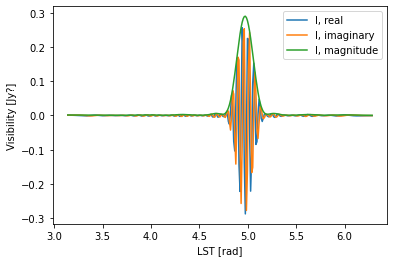

In [13]:
I = np.array([v[1][0] for v in vist])

plt.plot(vist[:, 0], np.real(I), label="I, real")
plt.plot(vist[:, 0], np.imag(I), label="I, imaginary")
plt.plot(vist[:, 0], np.abs(I), label="I, magnitude")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

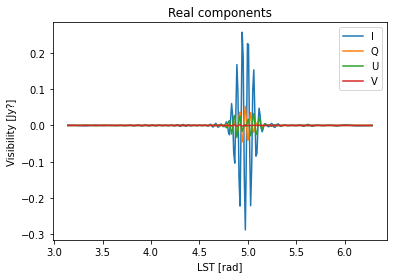

In [14]:
Q = np.array([v[1][1] for v in vist])
U = np.array([v[1][2] for v in vist])
V = np.array([v[1][3] for v in vist])

plt.plot(vist[:, 0], np.real(I), label="I")
plt.plot(vist[:, 0], np.real(Q), label="Q")
plt.plot(vist[:, 0], np.real(U), label="U")
plt.plot(vist[:, 0], np.real(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Real components")

plt.legend()
plt.show()

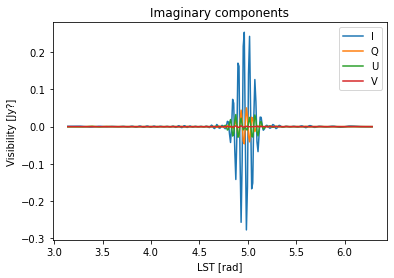

In [15]:
plt.plot(vist[:, 0], np.imag(I), label="I")
plt.plot(vist[:, 0], np.imag(Q), label="Q")
plt.plot(vist[:, 0], np.imag(U), label="U")
plt.plot(vist[:, 0], np.imag(V), label="V")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")
plt.title("Imaginary components")

plt.legend()
plt.show()

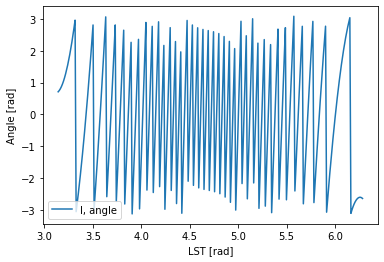

In [16]:
plt.plot(vist[:, 0], np.angle(I), label="I, angle")

plt.xlabel("LST [rad]")
plt.ylabel("Angle [rad]")

plt.legend()
plt.show()

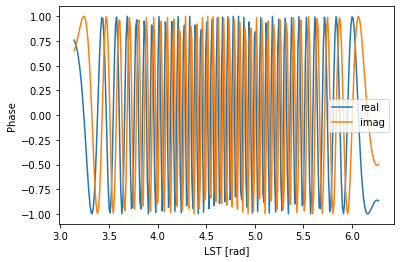

In [24]:
ra = np.radians(arbitrary_source.ra_angle)
dec = np.radians(arbitrary_source.dec_angle)
lst_list = [np.pi / 288 * i for i in range(288, 576)]

#print(lst_list)

phases = np.array([sf.ant.phase_factor(88, 121, sf.rot.radec2lm(ra, dec, ra0=lst)) for lst in 
    lst_list
])
plt.plot(lst_list, np.real(phases), label="real")
plt.plot(lst_list, np.imag(phases), label="imag")

plt.xlabel("LST [rad]")
plt.ylabel("Phase")

plt.legend()
plt.show()

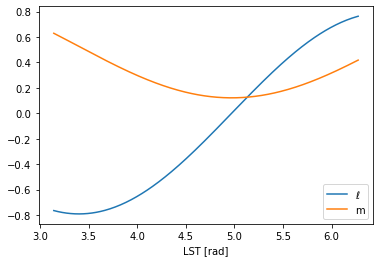

In [23]:
lst_list = [np.pi / 288 * i for i in range(288, 576)]

list_r = np.array([sf.rot.radec2lm(ra, dec, ra0=lst) for lst in 
    lst_list
])
plt.plot(lst_list, list_r[:, 0], label="$\ell$")
plt.plot(lst_list, list_r[:, 1], label="m")

plt.xlabel("LST [rad]")
#plt.ylabel("?")

plt.legend()
plt.show()

4.97096823571391 455.70480000000003 -0.657784051814753
[ 1.14575228e-03+0.j -1.12840718e-04+0.j  5.32793130e-04+0.j
 -3.69605882e-05+0.j]


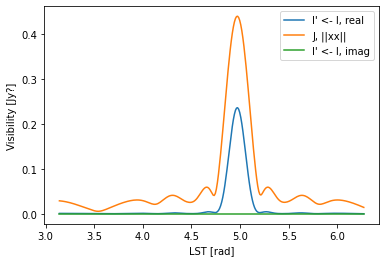

In [37]:
# this section is wrong. The magnitude should approach 1
    # I have checked to make sure dec != -30.72 deg is not the issue
        # (pure_J.ipynb indicated that I should expect some gaussian behavior
            # in dec, but fixing that value did not improve the results).

lst_list = [np.pi / 288 * i for i in range(288, 576)]

# constants for the LST plot
print(ra, ra * 288 / np.pi, dec)

list_A = []
list_J = []

for lst in lst_list:
    J = sf.stokes.create_J(ra=ra, dec=dec, lst=lst, radians=True)
    list_J.append(J)
    A = sf.stokes.create_A(J=J)
    list_A.append(A)

list_A = np.array(list_A)
list_J = np.array(list_J)
    
print(list_A[0][0][0])

plt.plot(lst_list, np.real(list_A[:, 0, 0, 0]), label="I' <- I, real")
plt.plot(lst_list, np.abs(list_J[:, 0, 0, 0]), label="J, ||xx||")
plt.plot(lst_list, np.imag(list_A[:, 0, 0, 0]), label="I' <- I, imag")

plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy?]")

plt.legend()
plt.show()

In [20]:
print("The following is the universal baseline")
print(sf.ant.baseline(88, 121))

The following is the universal baseline
[-43.92014994  25.13624112  -0.34038648]


In [21]:
len(sf.catalog.obj_catalog)

3872